In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from time import strptime
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import matthews_corrcoef, accuracy_score
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("bank-full.csv", sep = ";")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
#change month to numeric
data['month'] = [strptime(str(x), '%b').tm_mon for x in data['month']]

#change all object data type to categorical
list_str_obj_cols = data.columns[data.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    data[str_obj_col] = data[str_obj_col].astype("category")

#encode all categorical data
df_encoded = pd.get_dummies(data, columns=['job', 'marital', 'education', 'default', 
                                           'housing', 'loan', 'contact', 'poutcome'],)


#standardize all numeric data
data_numeric = data[["age", "balance", "day", "duration", "campaign", "pdays", "previous", "month"]]
 
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(data_numeric.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns = ["age", "balance", "day", "duration", "campaign", "pdays", "previous", "month"])
 
#combine both datasets
df_encoded.update(df_scaled)

#change class label to 0 and 1
df_encoded.y = pd.Categorical(df_encoded.y).codes
newdata = df_encoded

In [5]:
pd.set_option('display.max_columns', None)
newdata

,age,balance,day,month,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0.256419,-1.298476,-0.475354,0.011016,-0.569351,-0.411453,-0.251940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1
1,0.288529,-0.437895,-1.298476,-0.475354,-0.416127,-0.569351,-0.411453,-0.251940,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1
2,-0.747384,-0.446762,-1.298476,-0.475354,-0.707361,-0.569351,-0.411453,-0.251940,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1
3,0.571051,0.047205,-1.298476,-0.475354,-0.645231,-0.569351,-0.411453,-0.251940,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,1
4,-0.747384,-0.447091,-1.298476,-0.475354,-0.233620,-0.569351,-0.411453,-0.251940,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.947747,-0.176460,0.143418,2.016333,2.791329,0.076230,-0.411453,-0.251940,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1
45207,2.831227,0.120447,0.143418,2.016333,0.768224,-0.246560,-0.411453,-0.251940,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1
45208,2.925401,1.429593,0.143418,2.016333,3.373797,0.721811,1.436189,1.050473,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0
45209,1.512791,-0.228024,0.143418,2.016333,0.970146,0.399020,-0.411453,-0.251940,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1


In [6]:
X = newdata.drop(["y"], axis=1)
y = newdata["y"]

In [7]:
#used for parameter tuning
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .8)

In [8]:
X_train.shape

(36168, 40)

In [10]:
# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=50)
mcc_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Using Random Forest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute MCC for this fold and append to scores list
    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)

print(mcc_scores)
# Compute average MCC across all folds
average_mcc = sum(mcc_scores) / len(mcc_scores)
print(f"Average Matthews Correlation Coefficient over 5-folds: {average_mcc:.2f}")

[0.4428027215732341, 0.4500875762268728, 0.45666425615486056, 0.4405008685595771, 0.4299089754105361]
Average Matthews Correlation Coefficient over 5-folds: 0.44


In [24]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import matthews_corrcoef, accuracy_score

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mcc_scores_train = []
mcc_scores_test = []
accuracy_scores_train = []
accuracy_scores_test = []

for fold_num, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

 # Using Random Forest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Predict on training data
    y_pred_train = clf.predict(X_train)
    mcc_train = matthews_corrcoef(y_train, y_pred_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    mcc_scores_train.append(mcc_train)
    accuracy_scores_train.append(acc_train)
    
    # Predict on testing data
    y_pred_test = clf.predict(X_test)
    mcc_test = matthews_corrcoef(y_test, y_pred_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    mcc_scores_test.append(mcc_test)
    accuracy_scores_test.append(acc_test)

    # Print MCC and accuracy for this fold
    print(f"Fold {fold_num} - Train MCC: {mcc_train:.2f}, Test MCC: {mcc_test:.2f}, Train Accuracy: {acc_train:.2f}, Test Accuracy: {acc_test:.2f}")

# Compute average MCC and accuracy across all folds
average_mcc_train = sum(mcc_scores_train) / len(mcc_scores_train)
average_mcc_test = sum(mcc_scores_test) / len(mcc_scores_test)
average_acc_train = sum(accuracy_scores_train) / len(accuracy_scores_train)
average_acc_test = sum(accuracy_scores_test) / len(accuracy_scores_test)

print(f"\nAverage Train Matthews Correlation Coefficient over 5-folds: {average_mcc_train:.3f}")
print(f"Average Test Matthews Correlation Coefficient over 5-folds: {average_mcc_test:.3f}")
print(f"Average Train Accuracy over 5-folds: {average_acc_train:.3f}")
print(f"Average Test Accuracy over 5-folds: {average_acc_test:.3f}")

Fold 1 - Train MCC: 1.00, Test MCC: 0.46, Train Accuracy: 1.00, Test Accuracy: 0.90
Fold 2 - Train MCC: 1.00, Test MCC: 0.41, Train Accuracy: 1.00, Test Accuracy: 0.90
Fold 3 - Train MCC: 1.00, Test MCC: 0.44, Train Accuracy: 1.00, Test Accuracy: 0.90
Fold 4 - Train MCC: 1.00, Test MCC: 0.46, Train Accuracy: 1.00, Test Accuracy: 0.91
Fold 5 - Train MCC: 1.00, Test MCC: 0.44, Train Accuracy: 1.00, Test Accuracy: 0.90

Average Train Matthews Correlation Coefficient over 5-folds: 1.000
Average Test Matthews Correlation Coefficient over 5-folds: 0.443
Average Train Accuracy over 5-folds: 1.000
Average Test Accuracy over 5-folds: 0.903


In [12]:
# Oversampling using SMOTE
# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mcc_scores = []
accuracy_scores = []

for fold_num, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Oversampling using SMOTE
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Using Random Forest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test)

    # Compute MCC for this fold and append to scores list
    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)
    
    # Print MCC and accuracy for this fold
    print(f"Fold {fold_num} - MCC: {mcc:.2f}, Accuracy: {acc:.2f}")
    
# Compute average MCC and accuracy across all folds
average_mcc = sum(mcc_scores) / len(mcc_scores)
average_acc = sum(accuracy_scores) / len(accuracy_scores)
print(f"\nAverage Matthews Correlation Coefficient over 5-folds: {average_mcc:.2f}")
print(f"Average Accuracy over 5-folds: {average_acc:.2f}")

Fold 1 - MCC: 0.52, Accuracy: 0.89
Fold 2 - MCC: 0.48, Accuracy: 0.89
Fold 3 - MCC: 0.51, Accuracy: 0.89
Fold 4 - MCC: 0.53, Accuracy: 0.90
Fold 5 - MCC: 0.52, Accuracy: 0.90

Average Matthews Correlation Coefficient over 5-folds: 0.51
Average Accuracy over 5-folds: 0.90


In [25]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import matthews_corrcoef, accuracy_score

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mcc_scores_train = []
mcc_scores_test = []
accuracy_scores_train = []
accuracy_scores_test = []

for fold_num, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Oversampling using SMOTE
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Using Random Forest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test)
    
    # Predict on training data
    y_pred_train = clf.predict(X_train)
    mcc_train = matthews_corrcoef(y_train, y_pred_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    mcc_scores_train.append(mcc_train)
    accuracy_scores_train.append(acc_train)
    
    # Predict on testing data
    y_pred_test = clf.predict(X_test)
    mcc_test = matthews_corrcoef(y_test, y_pred_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    mcc_scores_test.append(mcc_test)
    accuracy_scores_test.append(acc_test)

    # Print MCC and accuracy for this fold
    print(f"Fold {fold_num} - Train MCC: {mcc_train:.2f}, Test MCC: {mcc_test:.2f}, Train Accuracy: {acc_train:.2f}, Test Accuracy: {acc_test:.2f}")

# Compute average MCC and accuracy across all folds
average_mcc_train = sum(mcc_scores_train) / len(mcc_scores_train)
average_mcc_test = sum(mcc_scores_test) / len(mcc_scores_test)
average_acc_train = sum(accuracy_scores_train) / len(accuracy_scores_train)
average_acc_test = sum(accuracy_scores_test) / len(accuracy_scores_test)

print(f"\nAverage Train Matthews Correlation Coefficient over 5-folds: {average_mcc_train:.3f}")
print(f"Average Test Matthews Correlation Coefficient over 5-folds: {average_mcc_test:.3f}")
print(f"Average Train Accuracy over 5-folds: {average_acc_train:.3f}")
print(f"Average Test Accuracy over 5-folds: {average_acc_test:.3f}")

Fold 1 - Train MCC: 1.00, Test MCC: 0.52, Train Accuracy: 1.00, Test Accuracy: 0.89
Fold 2 - Train MCC: 1.00, Test MCC: 0.49, Train Accuracy: 1.00, Test Accuracy: 0.90
Fold 3 - Train MCC: 1.00, Test MCC: 0.51, Train Accuracy: 1.00, Test Accuracy: 0.89
Fold 4 - Train MCC: 1.00, Test MCC: 0.52, Train Accuracy: 1.00, Test Accuracy: 0.90
Fold 5 - Train MCC: 1.00, Test MCC: 0.52, Train Accuracy: 1.00, Test Accuracy: 0.90

Average Train Matthews Correlation Coefficient over 5-folds: 1.000
Average Test Matthews Correlation Coefficient over 5-folds: 0.515
Average Train Accuracy over 5-folds: 1.000
Average Test Accuracy over 5-folds: 0.897


In [18]:
from sklearn.metrics import make_scorer, matthews_corrcoef
# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # increased max to 300 as more data often benefits from more trees
    'max_depth': [None, 20, 40, 60],  # increased the depth as with more data trees can be deeper
    'min_samples_split': [2, 5, 10, 20],  # increased max value as with more data, you can afford larger splits
    'min_samples_leaf': [1, 2, 4, 8]  # increased max value for similar reasons as min_samples_split
}

# Initialize GridSearchCV with 5-fold cross validation
grid_search = GridSearchCV(clf, param_grid,n_jobs=-1,verbose=2,cv=5, refit=True,
                           scoring = make_scorer(matthews_corrcoef))

# Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and their corresponding accuracy
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Optionally, you can use the best estimator directly
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  17.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  23.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  26.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   8.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  16.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=50; total time=   4.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=100; total time=   9.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=200; total time=  16.3s
[CV] E

[CV] END max_depth=40, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  15.3s
[CV] END max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   4.1s
[CV] END max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   8.1s
[CV] END max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  16.0s
[CV] END max_depth=40, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  22.0s
[CV] END max_depth=40, min_samples_leaf=2, min_samples_split=20, n_estimators=300; total time=  23.8s
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  15.8s
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  22.2s
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  22.9s
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=100; tota

[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   8.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  15.8s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  20.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=20, n_estimators=300; total time=  22.3s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=2, n_estimators=200; total time=  13.0s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=5, n_estimators=50; total time=   3.7s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=5, n_est

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  15.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   3.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  16.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   3.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   8.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estim

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  25.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  27.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   7.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  26.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=100; total time=   7.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=200; total time=  14.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_es

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  16.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   4.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  17.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  25.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  27.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=200; total time=  17.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=300; total time=  22.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_est

[CV] END max_depth=40, min_samples_leaf=2, min_samples_split=20, n_estimators=50; total time=   3.8s
[CV] END max_depth=40, min_samples_leaf=2, min_samples_split=20, n_estimators=50; total time=   3.4s
[CV] END max_depth=40, min_samples_leaf=2, min_samples_split=20, n_estimators=100; total time=   8.0s
[CV] END max_depth=40, min_samples_leaf=2, min_samples_split=20, n_estimators=200; total time=  14.9s
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.9s
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.7s
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.8s
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  15.6s
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   4.0s
[CV] END max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time

[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=20, n_estimators=200; total time=  15.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=20, n_estimators=300; total time=  21.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  23.9s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  16.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  23.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  22.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=20, n_estimators=100; total time=   7.3s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time=  13.5s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=2, n_estimators=50; total time=   3.8s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=2, n_e

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  26.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  16.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   8.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  17.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  24.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=300; total time=  24.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_e

Best parameters found:  {'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.67


In [32]:
pred = grid_search.best_estimator_.predict(X_test)#predict using test data
matthews_corrcoef(y_test, pred)

0.5147329105011038

In [19]:
grid_search.cv_results_
# 使用GridSearchCV找到的最佳模型对测试集进行预测
y_pred = grid_search.best_estimator_.predict(X_test)

# 计算在测试集上的MCC分数
mcc_score = matthews_corrcoef(y_test, y_pred)
print("MCC Score: ",mcc_score)

MCC Score:  0.5147329105011038
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=100; total time=   7.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=300; total time=  24.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  24.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  25.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  16.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  21.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=20, n_estimators=200; total time=  14.3s
[CV] END max_depth=None, min_samples_

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  15.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   7.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  14.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=50; total time=   4.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=50; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_est

[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.9s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  15.6s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.7s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.9s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  14.9s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   3.8s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   3.5s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   8.0s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total tim

[CV] END max_depth=60, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   7.2s
[CV] END max_depth=60, min_samples_leaf=8, min_samples_split=2, n_estimators=200; total time=  12.8s
[CV] END max_depth=60, min_samples_leaf=8, min_samples_split=5, n_estimators=50; total time=   3.9s
[CV] END max_depth=60, min_samples_leaf=8, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END max_depth=60, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=   7.2s
[CV] END max_depth=60, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=  14.8s
[CV] END max_depth=60, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=   3.9s
[CV] END max_depth=60, min_samples_leaf=8, min_samples_split=10, n_estimators=100; total time=   7.7s
[CV] END max_depth=60, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=  14.2s
[CV] END max_depth=60, min_samples_leaf=8, min_samples_split=10, n_estimators=300; total ti

[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.8s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  15.3s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.9s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  14.6s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   3.6s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   7.6s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estim

[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  15.4s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  20.7s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  22.8s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   7.5s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  13.8s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=20, n_estimators=50; total time=   3.9s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=20, n_estimators=50; total time=   3.6s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=20, n_estimators=100; total time=   7.5s
[CV] END max_depth=60, min_samples_leaf=4, min_samples_split=20, n_estimators=200; total time=  15.4s
[CV] END max_depth=60, min_samples_leaf=8, min_samples_split=2, n_estimators=50; total 

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  25.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  14.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   8.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  15.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  21.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=20, n_estimators=200; total time=  14.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_e

[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  15.8s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  21.8s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=20, n_estimators=300; total time=  22.1s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=2, n_estimators=200; total time=  13.8s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=2, n_estimators=300; total time=  19.8s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=5, n_estimators=300; total time=  22.7s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=10, n_estimators=100; total time=   6.2s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=10, n_estimators=300; total time=  22.3s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=20, n_estimators=100; total time=   6.4s
[CV] END max_depth=None, min_samples_leaf=8, min_samples_split=20, 

In [29]:
# 使用GridSearchCV找到的最佳模型对测试集进行预测
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred_test = clf.predict(X_test)

# 计算在测试集上的MCC分数
mcc_train = matthews_corrcoef(y_test, y_pred)
mcc_test = matthews_corrcoef(y_test, y_pred_test)
acc_score = accuracy_score(y_test, y_pred)
print("ACC Score: ",acc_score)
print(f"\nAverage Train Matthews Correlation Coefficient over 5-folds: {mcc_train:.3f}")
print(f"Average Test Matthews Correlation Coefficient over 5-folds: {mcc_test:.3f}")

ACC Score:  0.898363193983632

Average Train Matthews Correlation Coefficient over 5-folds: 0.515
Average Test Matthews Correlation Coefficient over 5-folds: 0.517


In [33]:
importances = clf.feature_importances_
features_list = [
    "age", "balance", "day", "month", "duration", "campaign", "pdays", "previous", "y",
    "job_admin.", "job_blue-collar", "job_entrepreneur", "job_housemaid", "job_management",
    "job_retired", "job_self-employed", "job_services", "job_student", "job_technician",
    "job_unemployed", "job_unknown", "marital_divorced", "marital_married", "marital_single",
    "education_primary", "education_secondary", "education_tertiary", "education_unknown",
    "default_no", "default_yes", "housing_no", "housing_yes", "loan_no", "loan_yes",
    "contact_cellular", "contact_telephone", "contact_unknown", "poutcome_failure",
    "poutcome_other", "poutcome_success", "poutcome_unknown"
]
for feature, importance in zip(features_list, importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: age, Importance: 0.057922032191575275
Feature: balance, Importance: 0.06934638781330543
Feature: day, Importance: 0.05987375160993561
Feature: month, Importance: 0.08697162256550622
Feature: duration, Importance: 0.3164188887940248
Feature: campaign, Importance: 0.08083400714243705
Feature: pdays, Importance: 0.02548695706734
Feature: previous, Importance: 0.026636887609144802
Feature: y, Importance: 0.005185976808407705
Feature: job_admin., Importance: 0.010518701438347766
Feature: job_blue-collar, Importance: 0.0029340183659471394
Feature: job_entrepreneur, Importance: 0.0028739326552504763
Feature: job_housemaid, Importance: 0.006502617761147626
Feature: job_management, Importance: 0.003213293146463178
Feature: job_retired, Importance: 0.003695033323352928
Feature: job_self-employed, Importance: 0.004946295400794332
Feature: job_services, Importance: 0.0019635618796833396
Feature: job_student, Importance: 0.006737799055313763
Feature: job_technician, Importance: 0.002738953

In [34]:
# 结合 features 和 importances，然后根据重要性进行排序
sorted_features = sorted(zip(features_list, importances), key=lambda x: x[1], reverse=True)

# 打印前20个特征及其重要性
for i, (feature, importance) in enumerate(sorted_features[:20]):
    print(f"Rank {i+1} - Feature: {feature}, Importance: {importance}")

Rank 1 - Feature: duration, Importance: 0.3164188887940248
Rank 2 - Feature: month, Importance: 0.08697162256550622
Rank 3 - Feature: campaign, Importance: 0.08083400714243705
Rank 4 - Feature: balance, Importance: 0.06934638781330543
Rank 5 - Feature: day, Importance: 0.05987375160993561
Rank 6 - Feature: age, Importance: 0.057922032191575275
Rank 7 - Feature: contact_telephone, Importance: 0.03623918981880263
Rank 8 - Feature: housing_no, Importance: 0.034600551320797486
Rank 9 - Feature: previous, Importance: 0.026636887609144802
Rank 10 - Feature: pdays, Importance: 0.02548695706734
Rank 11 - Feature: poutcome_other, Importance: 0.02067014212007447
Rank 12 - Feature: default_yes, Importance: 0.014410215891508097
Rank 13 - Feature: loan_no, Importance: 0.014272384473475837
Rank 14 - Feature: loan_yes, Importance: 0.013936995316629416
Rank 15 - Feature: contact_unknown, Importance: 0.012430158092990166
Rank 16 - Feature: job_admin., Importance: 0.010518701438347766
Rank 17 - Feature:

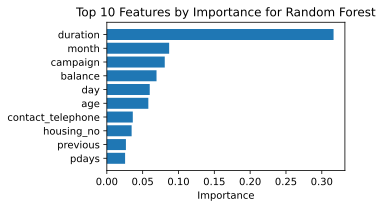

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sorted_features = sorted(zip(features_list, importances), key=lambda x: x[1], reverse=True)

# 获取前10个特征及其重要性
top_features = [feature for feature, importance in sorted_features[:10]]
top_importances = [importance for feature, importance in sorted_features[:10]]

# 创建条形图
plt.figure(figsize=(5,3))
plt.barh(top_features, top_importances, align='center')
plt.xlabel('Importance')
plt.title('Top 10 Features by Importance for Random Forest')
plt.gca().invert_yaxis()  # 反转y轴，以便最重要的特征在顶部
plt.tight_layout()
plt.show()